# NLP Project

In this project, you are expected to perform NLP on an online dataset that you will obtain from an API or scraping.

This is an open-ended project, and you can be creative!

### Requirements:
- Obtain data from an API or web-scraping. No premade datasets from Kaggle!
- You are epxected to work on some form of **text data**.
- Your goal is to uncover underlying clusters (social communities, market patters) etc., using unsupervised learning.
- You can use any method; clustering, sentiment analysis, dimensionality reduction, pretrained models, word-embeddings, network embeddings, etc.
- Create a visualization in 2d or 3d of the data with the clusters you found tagged. See reddit example below.
- Analyze the produced clusters and use them to provide a short explanation of what you found.

Reddit example visualization:

![](reddit.png)

**You don't have to do it at a large scale**

The data for these sort of projects can run very large if you let them, making the enterprise difficult.

You can limit yourself to samples of the communities you're looking at rather than the entire thing.

Please focus on exploring multiple techniques, understanding which ones would be most applicable, and interpreting the final results.

### Good Luck!

In [660]:
# Imports
# !pip install google-play-scraper
# !pip install emoji
from google_play_scraper import reviews
import pandas as pd
import re
import emoji
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

## Web Scraping

In [631]:
# Scrape 10000 reviews for Instagram because more would take way too long
result, _ = reviews('com.instagram.android', lang='en', country='ca', count=10000)

In [632]:
# Save to df
df = pd.DataFrame(result)

In [633]:
# Save as CSV
df.to_csv('instagram_reviews_NPL_Project.csv', index=False)

In [634]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,398cefda-d3b2-4f8b-ace8-d9b37049bda7,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Full of fun,5,0,None,2025-04-22 20:04:48,None,None,None
1,a9ee458f-a5d0-408e-83db-c7912c8cd684,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,instagram update your fonts please,4,0,None,2025-04-22 20:01:47,None,None,None
2,4e317c0e-7693-4c8c-9e92-128c4fc8560a,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Nice app,5,0,376.1.0.55.68,2025-04-22 19:59:59,None,None,376.1.0.55.68
3,9046bd09-779e-42a9-8c12-63f691822580,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,good,5,0,None,2025-04-22 19:56:53,None,None,None
4,9931a79f-aff4-4692-a227-f5641d70736b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,bom,5,0,None,2025-04-22 19:56:42,None,None,None


In [635]:
df.tail()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
9995,d7908cf0-1707-491e-8e18-c125a586debe,PHANTOM NINJA,https://play-lh.googleusercontent.com/a-/ALV-U...,"Love the new features, enhancements and overal...",5,0,375.0.0.38.66,2025-04-12 16:08:56,None,None,375.0.0.38.66
9996,370c93df-5cd4-431a-b0b1-27347e688df5,Matodzi Mirriam,https://play-lh.googleusercontent.com/a/ACg8oc...,marvelousssss,5,0,375.0.0.38.66,2025-04-12 16:06:17,None,None,375.0.0.38.66
9997,73fe3365-8a45-42da-b43c-a5756a70f593,Koos Jiemies,https://play-lh.googleusercontent.com/a-/ALV-U...,Good,3,0,375.0.0.38.66,2025-04-12 16:02:50,None,None,375.0.0.38.66
9998,3011e0e7-1640-4808-9ef0-c486189393a5,Brajesh Patel,https://play-lh.googleusercontent.com/a/ACg8oc...,👍,5,0,373.0.0.46.67,2025-04-12 15:58:18,None,None,373.0.0.46.67
9999,bd2c20eb-d22d-430e-9a07-82f4e02d1e62,AkKu Sain,https://play-lh.googleusercontent.com/a-/ALV-U...,❤️❤️,5,0,375.0.0.38.66,2025-04-12 15:57:45,None,None,375.0.0.38.66


In [636]:
df.sample(20)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
5485,3867f18c-cb93-4d6a-b062-d39c9f32bf20,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's simply to use and with more great features,5,0,376.0.0.52.68,2025-04-17 19:15:29,None,None,376.0.0.52.68
7543,3b9686d2-c6fb-4e14-801d-30d1593c97bc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Bluetooth calling problem,1,0,375.0.0.38.66,2025-04-15 10:32:02,None,None,375.0.0.38.66
9801,27ec90f5-08b2-495a-9836-67a84b608f59,MD ARSAD,https://play-lh.googleusercontent.com/a-/ALV-U...,best 👌,5,0,373.0.0.46.67,2025-04-13 00:30:34,None,None,373.0.0.46.67
3046,4652196c-0a8e-4e0a-bd56-b299ec379ee1,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,They suspend your account for not getting on t...,1,0,376.1.0.55.68,2025-04-20 07:46:22,None,None,376.1.0.55.68
8009,79ea9d18-621a-4332-b4d3-5e6bf81a8379,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,supar viral my vedio love you instagarm,5,0,None,2025-04-15 00:01:47,None,None,None
2910,c886ad36-c5df-47e5-aa57-651e07349262,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice app,5,0,None,2025-04-20 10:36:28,None,None,None
8025,536aac29-929a-4c6a-b935-6e031903abfe,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice work to but 🤗🙂,4,0,359.2.0.64.89,2025-04-14 23:35:25,None,None,359.2.0.64.89
2507,8e5eaed8-c783-4544-94f9-b4a90b12ba7b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,insta very best,5,0,376.1.0.55.68,2025-04-20 23:52:15,None,None,376.1.0.55.68
5535,34444243-bebe-4d41-98d5-15fd61a20331,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,bakwas,1,0,375.0.0.38.66,2025-04-17 16:13:42,None,None,375.0.0.38.66
7166,67f09662-5c78-4327-abef-a136da665f29,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,best,5,0,None,2025-04-15 22:39:41,None,None,None


In [637]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              10000 non-null  object        
 1   userName              10000 non-null  object        
 2   userImage             10000 non-null  object        
 3   content               10000 non-null  object        
 4   score                 10000 non-null  int64         
 5   thumbsUpCount         10000 non-null  int64         
 6   reviewCreatedVersion  7297 non-null   object        
 7   at                    10000 non-null  datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  appVersion            7297 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 859.5+ KB


## Data Preprocessing

In [639]:
# Only keep content
df = df[['content']]

In [640]:
words = df['content'].str.split()
words = pd.DataFrame(words.tolist())
words.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,Full,of,fun,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,instagram,update,your,fonts,please,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Nice,app,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,good,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,bom,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [641]:
replaceDict = {
    '{': " ", '}': " ", ',': "", '.': " ", '!': " ", '\\': " ", '/': " ", '$': " ", '%': " ",
    '^': " ", '?': " ", '\'': " ", '"': " ", '(': " ", ')': " ", '*': " ", '+': " ", '-': " ",
    '=': " ", ':': " ", ';': " ", ']': " ", '[': " ", '`': " ", '~': " ",
}

# Emoji removal function
def remove_emojis(text):

    text = emoji.replace_emoji(text, replace='')    
    return text

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile('|'.join(rep.keys()))

def replacer(text):
    return rep[re.escape(text.group(0))]

words = (df['content']
         .apply(remove_emojis)
         .str.replace(pattern, replacer, regex=True)
         .str.lower()
         .str.split())

words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,full,of,fun,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,instagram,update,your,fonts,please,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,nice,app,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,good,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,bom,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,love,the,new,features,enhancements,and,overall,improvements,None,None,...,None,None,None,None,None,None,None,None,None,None
9996,marvelousssss,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9997,good,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9998,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [642]:
# Join back tokens, internet says it's better that way
docs = words.fillna('').apply(lambda row: ' '.join(row), axis=1)

In [643]:
# TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(docs)

In [644]:
# Clustering
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)
df['cluster'] = clusters

In [645]:
df[['content', 'cluster']].groupby('cluster').head(3)

,content,cluster
0,Full of fun,1
1,instagram update your fonts please,1
2,Nice app,1
3,good,3
5,It's all good 👍 9 I love Instagram they rock,2
6,love it,2
7,good app,3
16,its good,3
27,Best app in the world 🌎,4
31,best,4


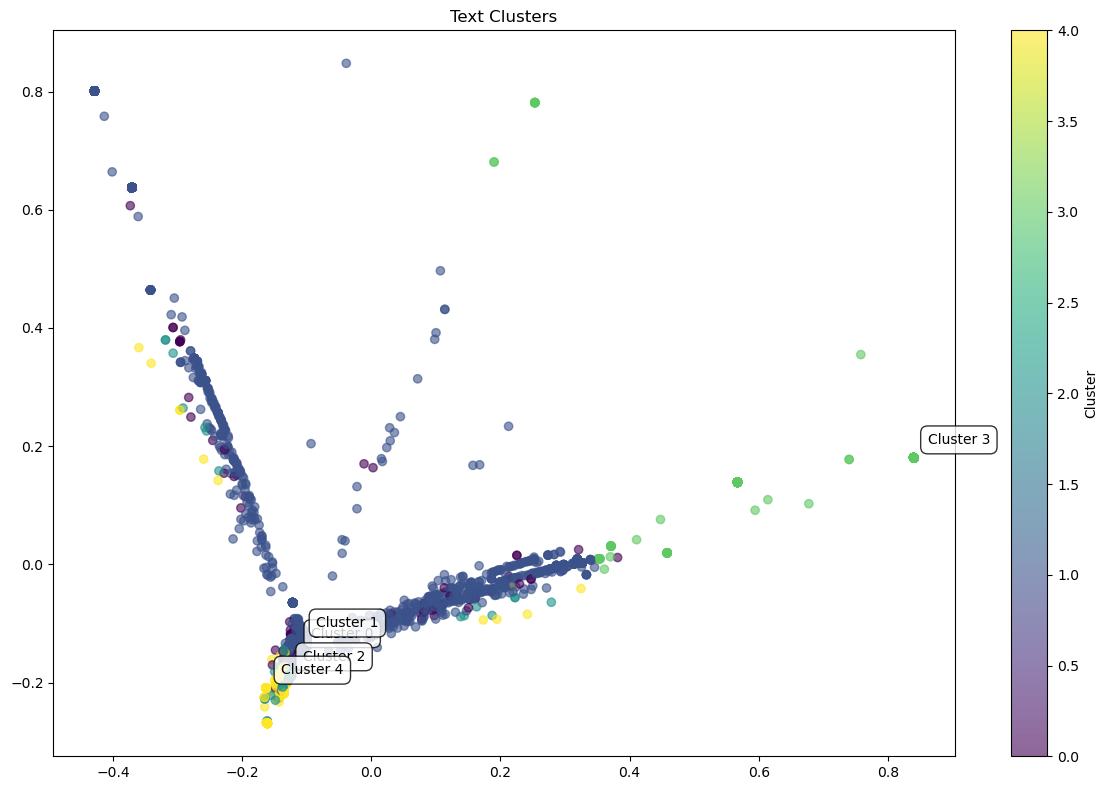

In [664]:
# Ensure that arrays are aligned
valid_indices = ~df['content'].isna()
X_filtered = X[valid_indices]
clusters_filtered = clusters[valid_indices]

# Dimentions reduction
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_filtered.toarray())

#  Create df for graph
cluster_viz = pd.DataFrame({'x': X_2d[:, 0], 'y': X_2d[:, 1], 'cluster': clusters_filtered, 'text': df.loc[valid_indices, 'content'].str.wrap(30)})

# Graph
plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_viz['x'], cluster_viz['y'], c=cluster_viz['cluster'], cmap='viridis', alpha=0.6)
plt.title("Text Clusters")
plt.colorbar(scatter, label='Cluster')

# Labels
for cluster_num in range(k):
    cluster_data = cluster_viz[cluster_viz['cluster'] == cluster_num]
    median_x = cluster_data['x'].median()
    median_y = cluster_data['y'].median()    
    plt.annotate(
        f"Cluster {cluster_num}",
        xy=(median_x, median_y),
        xytext=(10, 10),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.tight_layout()
plt.show()

I am struggling with this whole NLP thing but I think that the graoh shows that there are outliers that need to be removed.